# Handling outliers

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

**An outlier is a data point that is significantly different from the remaining data.** 

Outlierji močno vplivajo na statistične značilnosti, zato jih v določenih primerih želimo izločiti.


## Trimming outliers from the dataset

**Trimming, or truncating, is the process of removing observations that show outliers in one
or more variables in the dataset.** 



In [2]:
boston = pd.read_csv("data/boston.csv")
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


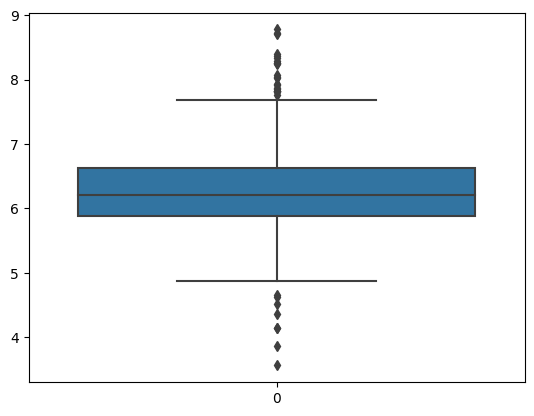

In [3]:
# The outliers are the asterisks sitting outside the whiskers, which delimit the interquartile range proximity rule boundaries:
sns.boxplot(boston['RM'])
plt.show()

- inter-quartile: pri normalni distribuciji rečemo, da so outlierji tiste vrednosti, ki so več kot 3krat oddaljene od avg+-varianca
- meanstddev: pri ostalih distribucijah naredimo neko oceno in recimo odstranimo npr 1.5% top in bottom vrednosti

In [11]:
def find_boundaries(df, variable, distance, rule="inter-quartile"): # parameter distance -> vezano na večkratnih st.dev, ki ga želimo ohraniti
    if rule == "inter-quartile":
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
        return upper_boundary, lower_boundary
    elif rule == "meanstddev":
        lower_boundary = df[variable].mean() - (df[variable].std() * distance)
        upper_boundary = df[variable].mean() + (df[variable].std() * distance)
        return upper_boundary, lower_boundary

In [5]:
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 1.5)

In [6]:
# Let's print those limits beyond which we will consider a value an outlier:
RM_upper_limit, RM_lower_limit

(7.730500000000001, 4.778499999999999)

In [7]:
outliers_RM = np.where(boston['RM'] > RM_upper_limit, True, np.where(boston['RM'] < RM_lower_limit, True, False))
boston_trimmed = boston.loc[~(outliers_RM)]

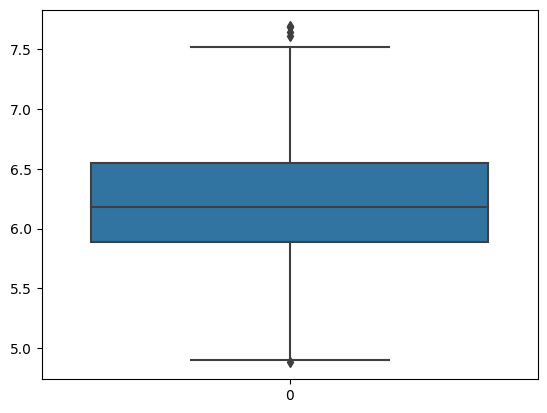

In [8]:
sns.boxplot(boston_trimmed['RM'])
plt.show()

In [9]:
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 3, rule="meanstddev")
RM_upper_limit, RM_lower_limit

(8.392485817597748, 4.176782957105809)

## Performing winsorization

**Winsorization, or winsorizing, is the process of transforming the data by limiting the
extreme values, that is, the outliers, to a certain arbitrary value, closer to the mean of the distribution**.


In [12]:
boston = pd.read_csv("data/boston.csv")
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
import scipy.stats as stats

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

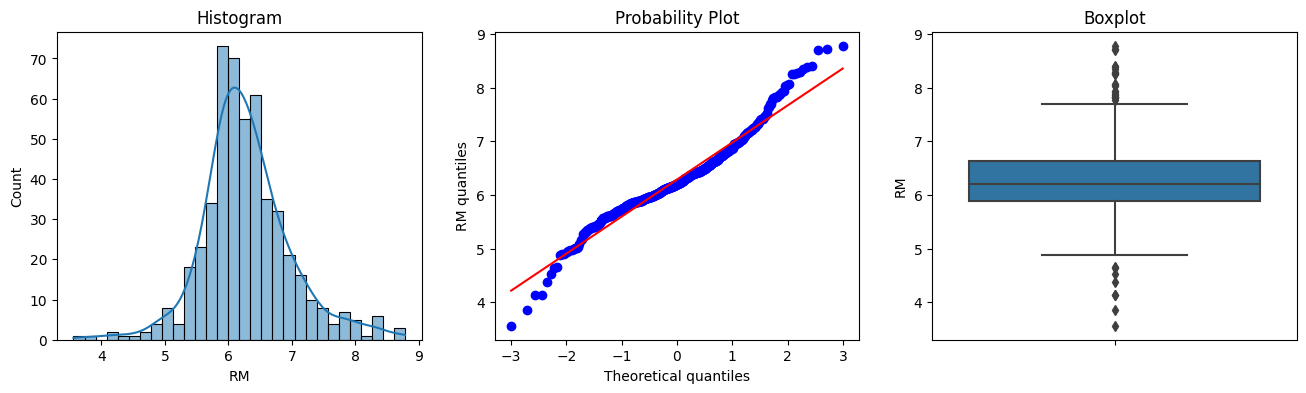

In [14]:
diagnostic_plots(boston, 'RM')

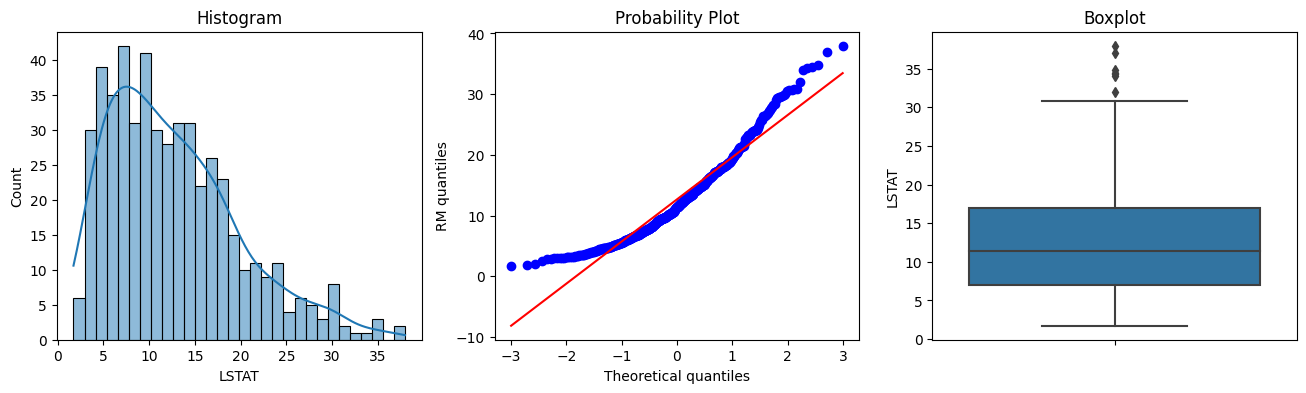

In [15]:
diagnostic_plots(boston, 'LSTAT')

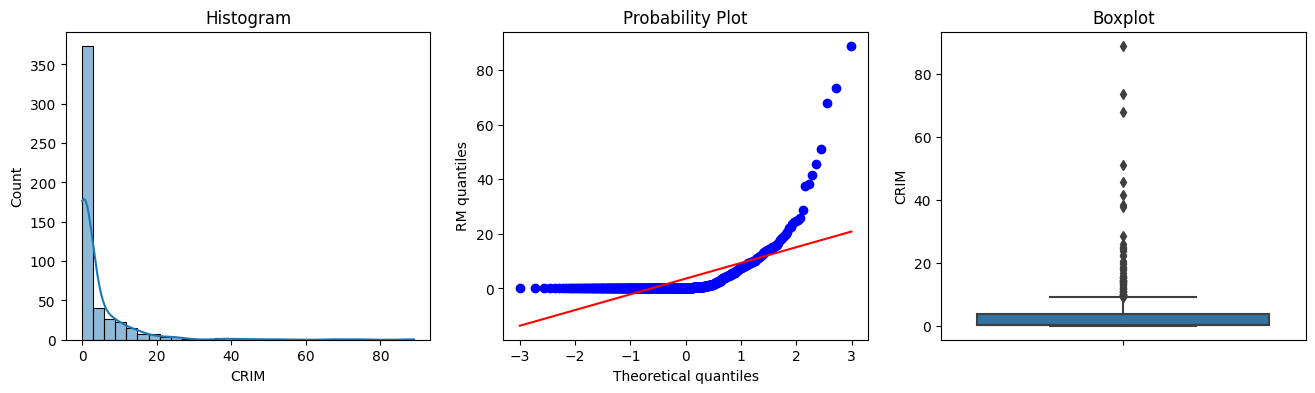

In [16]:
diagnostic_plots(boston, 'CRIM')

In [17]:
from feature_engine.outliers import Winsorizer

windsorizer = Winsorizer(capping_method='quantiles', 
                          tail='both', # cap left, right or both tails 
                          variables=['RM', 'LSTAT', 'CRIM'])

windsorizer.fit(boston)

Winsorizer(capping_method='quantiles', fold=0.05, tail='both',
           variables=['RM', 'LSTAT', 'CRIM'])

In [18]:
boston_t = windsorizer.transform(boston)

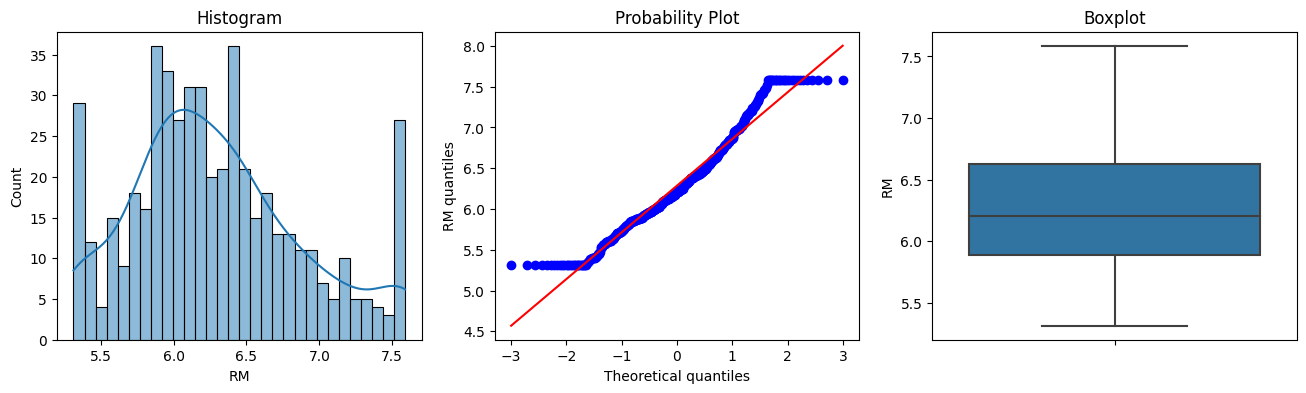

In [19]:
diagnostic_plots(boston_t, 'RM')

In [20]:
# we can inspect the minimum caps for each variable
windsorizer.left_tail_caps_

{'RM': 5.314, 'LSTAT': 3.7075, 'CRIM': 0.027909999999999997}

In [21]:
# we can inspect the maximum caps for each variable
windsorizer.right_tail_caps_

{'RM': 7.5875, 'LSTAT': 26.8075, 'CRIM': 15.78915}

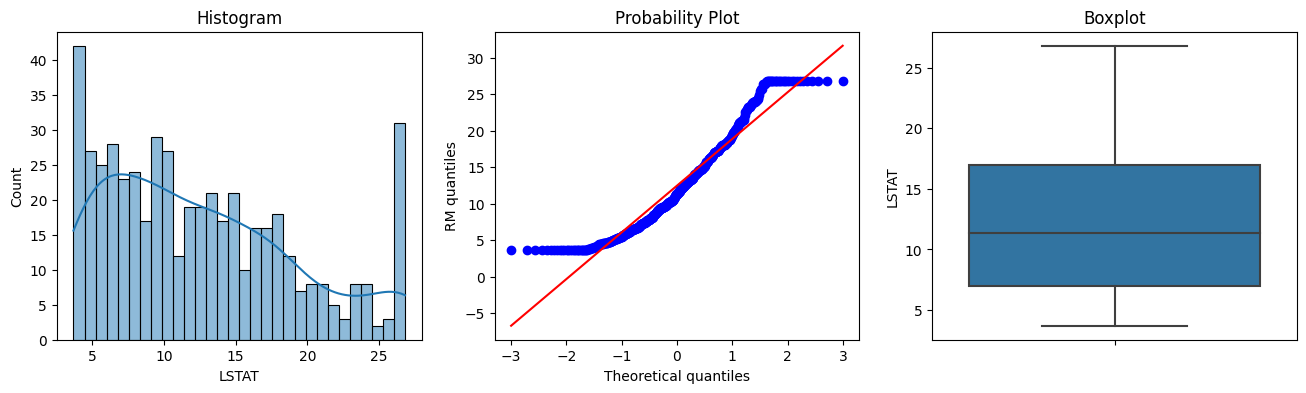

In [22]:
diagnostic_plots(boston_t, 'LSTAT')

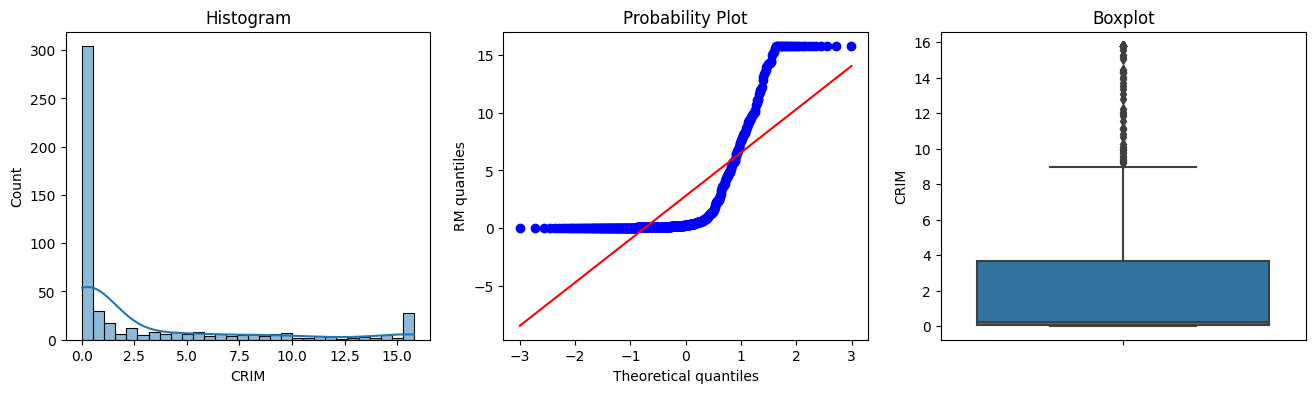

In [23]:
diagnostic_plots(boston_t, 'CRIM')

## Capping the variable at arbitrary maximum and minimum values

In [24]:
boston = pd.read_csv("data/boston.csv")
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [25]:
from feature_engine.outliers import Winsorizer

windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsorizer.fit(boston)

Winsorizer(tail='both', variables=['RM', 'LSTAT', 'CRIM'])

In [26]:
boston_t = windsorizer.transform(boston)

In [27]:
# we can inspect the minimum caps for each variable
windsorizer.left_tail_caps_

{'RM': 4.178866844348072,
 'LSTAT': -8.748941668844733,
 'CRIM': -22.16560049657506}

In [28]:
# we can inspect the maximum caps for each variable
windsorizer.right_tail_caps_

{'RM': 8.390401930355486,
 'LSTAT': 34.05506815105818,
 'CRIM': 29.392647611199564}